# Usage of eABF and WTMeABF

We will again analyze the improper dihedral of ammiona as in 16

To analyse the umbrella sampling results, please install [adaptive-sampling](https://github.com/ochsenfeld-lab/adaptive_sampling) package:
```bash
pip install git+https://github.com/ochsenfeld-lab/adaptive_sampling@bff1ef1
```

Note: this notebook relies on an old and unstable version of the adaptive-sampling package.

### Imports

In [ ]:
import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
from adaptive_sampling.processing_tools import mbar
from ase.io import Trajectory as trajectory
from ase.io import read

from nff.io.ase import AtomsBatch
from nff.io.bias_calculators import WTMeABF, eABF
from nff.md.colvars import ColVar
from nff.md.nvt import Langevin
from nff.md.utils import BiasedNeuralMDLogger
from nff.train import load_model

plt.style.use("default")

### Loading the starting structure 

In [2]:
start_geom = read("models/ammonia/Ammonia.xyz")

In [3]:
# central dictionary for the ColVar class
# in this tutorial we will use the improper dihedral of ammonia
info_dict = {
    "name": "dihedral",
    "index_list": [0, 1, 2, 3],
}

device = "cpu"

atoms = AtomsBatch.from_atoms(start_geom, device=device)

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

print(f"Start value: {cv*180/np.pi} degrees = {cv} radians")

Start value: 42.17880578196517 degrees = 0.7361590354545137 radians


### Setting up eABF

In [4]:
cv_defs = [
    {
        "definition": info_dict,
        "range": [-1.0, 1.0],
        "ext_sigma": 0.05,  # approx k = 10 eV/(cv-unit)^2
        "ext_mass": 20.0,
        "ext_pos": cv,  # the starting position of the extended coordinate
        "margin": 0.1,
        "conf_k": 0.1,
        "type": "angle",
    }
]

model = load_model("models/ammonia/", device=device)

calculator = eABF(
    model,
    cv_defs=cv_defs,
    dt=0.5,
    friction_per_ps=1.0,
    equil_temp=300.0,
    nfull=100,
    directed=True,
    device=device,
)

atoms.set_calculator(calculator)

dyn = Langevin(
    atoms,
    timestep=0.5,
    temperature=300.0,
    friction_per_ps=1.0,
    maxwell_temp=300.0,
    logfile="eABF_MD.log",
    trajectory="eABF.traj",
)

dyn.attach(BiasedNeuralMDLogger(dyn, atoms, "eABF_ext.log", header=True, mode="w"), interval=2)

THE RANDOM NUMBER SEED WAS: 1714694634


In [5]:
# trajectory of 25 ps (umbrella sampling was 41 ps)
dyn.run(steps=int(5e4))

100%|██████████| 2500/2500 [04:42<00:00,  8.84it/s]


In [6]:
traj = trajectory("eABF.traj", mode="r")
nv.show_asetraj(traj)

NGLWidget(max_frame=50000)

In [7]:
exttraj = np.genfromtxt("eABF_ext.log", skip_header=1)

In [8]:
!head -n 1 eABF_ext.log

Time[ps]    U0+bias[eV]       U0[eV]   AbsGradPot           CV       Lambda     inv_m_cv    AbsGradCV GradCV_GradU 


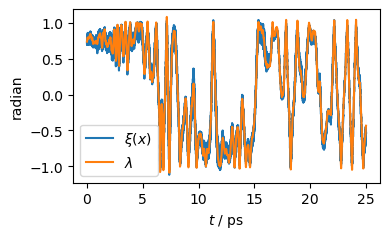

In [9]:
fig, ax = plt.subplots(figsize=(4, 2.5), layout="tight")

ax.plot(exttraj[:, 0], exttraj[:, 4], label=r"$\xi(x)$")
ax.plot(exttraj[:, 0], exttraj[:, 5], label=r"$\lambda$")

ax.set_xlabel(r"$t$ / ps")
ax.set_ylabel(r"radian")

ax.legend(loc="best", frameon=True)

fig.show()

In [10]:
# coupling width of the eABF simulation,
# do not change this! this is the value from the simulation
sigma = 0.05

# parameters for the grid for which the trajectory
# is split into fictional umbrella windows
dxi = sigma
min_xi = -1.0
max_xi = 1.0
grid = np.arange(min_xi, max_xi, dxi)

# this function needs the CV-values and the coupled extended variable
traj_cv = exttraj[:, 4]
traj_lam = exttraj[:, 5]

traj_list, indices, meta_f = mbar.get_windows(grid, traj_cv, traj_lam, sigma, equil_temp=300.0)

In [11]:
W = mbar.run_mbar(traj_list, meta_f, equil_temp=300.0, outfreq=50, conv=1.0e-6, max_iter=int(1e6))

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  1.5598611013	Conv_errvec=    346.383180
Iter   50:	Conv=  0.0708319566	Conv_errvec=     23.992468
Iter  100:	Conv=  0.0195939241	Conv_errvec=      8.211595
Iter  150:	Conv=  0.0048518274	Conv_errvec=      3.391762
Iter  200:	Conv=  0.0020722732	Conv_errvec=      1.821327
Iter  250:	Conv=  0.0018208710	Conv_errvec=      1.239327
Iter  300:	Conv=  0.0015352935	Conv_errvec=      0.946506
Iter  350:	Conv=  0.0012768642	Conv_errvec=      0.759192
Iter  400:	Conv=  0.0010569227	Conv_errvec=      0.620339
Iter  450:	Conv=  0.0008734223	Conv_errvec=      0.510285
Iter  500:	Conv=  0.0007213625	Conv_errvec=      0.420755
Iter  550:	Conv=  0.0005956543	Conv_errvec=      0.347225
Iter  600:	Conv=  0.0004918171	Conv_errvec=      0.286630
Iter  650:	Conv=  0.0004060709	Conv_errvec=      0.236636
Iter  700:	Conv=  0.0003352710	Conv_errvec=      0.195369
Iter  750:	Conv=  0.0002768144	Conv_errvec=      0.1

In [12]:
pmf, rho = mbar.pmf_from_weights(grid, traj_cv[indices], W, equil_temp=300.0)

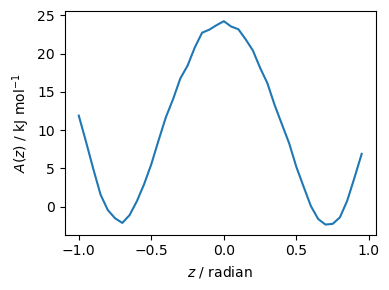

In [13]:
fig, ax = plt.subplots(figsize=(4, 3), layout="tight")

ax.plot(grid, pmf)

ax.set_xlabel(r"$z$ / radian")
ax.set_ylabel(r"$A(z)$ / kJ mol$^{-1}$")

fig.show()

### WTMeABF

In [14]:
# Let's start exactly where the other simulation started
atoms = AtomsBatch.from_atoms(start_geom, device=device)

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

In [15]:
# Most things look very similar to eABF
# The differences are:
# - hill_std in the cv dictionary, because
#    one might want to specify different Gaussian
#    hill width for different cvs
# - The calculator has now the additional hill depostion related options

cv_defs = [
    {
        "definition": info_dict,
        "range": [-1.0, 1.0],
        "ext_sigma": 0.05,  # approx k = 10 eV/A^2 = 1000 kJ/mol A^2
        "ext_mass": 20.0,
        "ext_pos": cv,
        "margin": 0.1,
        "conf_k": 0.1,
        "hill_std": 0.025,
        "type": "angle",
    },
]

model = load_model("models/ammonia/", device=device)

calculator = WTMeABF(
    model,
    cv_defs=cv_defs,
    dt=0.5,
    friction_per_ps=1.0,
    equil_temp=300.0,
    nfull=100,
    hill_height=0.01,
    hill_drop_freq=100,
    directed=True,
    device=device,
)

atoms.set_calculator(calculator)

dyn = Langevin(
    atoms,
    timestep=0.5,
    temperature=300.0,
    friction_per_ps=1.0,
    maxwell_temp=300.0,
    logfile="WTMeABF_MD.log",
    trajectory="WTMeABF.traj",
)

dyn.attach(BiasedNeuralMDLogger(dyn, atoms, "WTMeABF_ext.log", header=True, mode="w"), interval=2)

THE RANDOM NUMBER SEED WAS: 1937857921


In [16]:
# trajectory of 10 ps (umbrella sampling was 41 ps, eABF 25 ps)
# This is to show the power, one can always sample the same amount
dyn.run(steps=int(2e4))

100%|██████████| 1000/1000 [01:55<00:00,  8.64it/s]


In [17]:
traj = trajectory("WTMeABF.traj", mode="r")
exttraj = np.genfromtxt("WTMeABF_ext.log", skip_header=1)

In [18]:
nv.show_asetraj(traj)

NGLWidget(max_frame=20000)

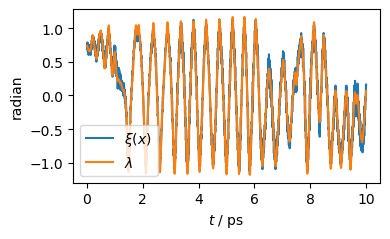

In [19]:
fig, ax = plt.subplots(figsize=(4, 2.5), layout="tight")

ax.plot(exttraj[:, 0], exttraj[:, 4], label=r"$\xi(x)$")
ax.plot(exttraj[:, 0], exttraj[:, 5], label=r"$\lambda$")

ax.set_xlabel(r"$t$ / ps")
ax.set_ylabel(r"radian")

ax.legend(loc="best", frameon=True)

fig.show()

In [20]:
# all parameters are pretty much as before
# this function needs the CV-values and the coupled extended variable
traj_cv = exttraj[:, 4]
traj_lam = exttraj[:, 5]

traj_list, indices, meta_f = mbar.get_windows(grid, traj_cv, traj_lam, sigma, equil_temp=300.0)

In [21]:
W = mbar.run_mbar(traj_list, meta_f, equil_temp=300.0, outfreq=50, conv=1.0e-6, max_iter=int(1e6))

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  1.4354207064	Conv_errvec=     91.378262
Iter   50:	Conv=  0.0697425389	Conv_errvec=     11.149506
Iter  100:	Conv=  0.0179489652	Conv_errvec=      3.015998
Iter  150:	Conv=  0.0039559958	Conv_errvec=      1.049843
Iter  200:	Conv=  0.0020328243	Conv_errvec=      0.465964
Iter  250:	Conv=  0.0015355385	Conv_errvec=      0.266458
Iter  300:	Conv=  0.0011254543	Conv_errvec=      0.174710
Iter  350:	Conv=  0.0008159449	Conv_errvec=      0.121159
Iter  400:	Conv=  0.0005891632	Conv_errvec=      0.085996
Iter  450:	Conv=  0.0004247670	Conv_errvec=      0.061595
Iter  500:	Conv=  0.0003060677	Conv_errvec=      0.044272
Iter  550:	Conv=  0.0002204908	Conv_errvec=      0.031863
Iter  600:	Conv=  0.0001588283	Conv_errvec=      0.022944
Iter  650:	Conv=  0.0001144069	Conv_errvec=      0.016525
Iter  700:	Conv=  0.0000824084	Conv_errvec=      0.011902
Iter  750:	Conv=  0.0000593593	Conv_errvec=      0.0

In [22]:
pmf, rho = mbar.pmf_from_weights(grid, traj_cv[indices], W, equil_temp=300.0)

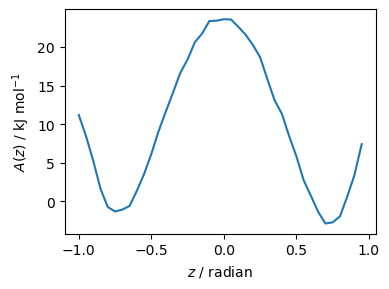

In [23]:
fig, ax = plt.subplots(figsize=(4, 3), layout="tight")

ax.plot(grid, pmf)

ax.set_xlabel(r"$z$ / radian")
ax.set_ylabel(r"$A(z)$ / kJ mol$^{-1}$")

fig.show()